## Relax Data Science Challenge

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
parse_dates=['time_stamp']
userEngagement = pd.read_csv('./takehome_user_engagement.csv', parse_dates=parse_dates)

parse_dates = ['creation_time']
users = pd.read_csv('./takehome_users.csv', sep=';',encoding='latin-1',parse_dates=parse_dates)

### Engineer Features

In [3]:
userFeatureEngineering = []

for x in userEngagement.user_id.unique():
    sub = userEngagement[userEngagement.user_id == x]
    sub['ISO'] = [y.isoformat() for y in sub.time_stamp]
    sub = sub.drop_duplicates(subset=['ISO'])
    sub = sub.sort_values(by='time_stamp')
    
    userAdopted = False
    
    #Checks every group of three timestamps (in order)
    #for the case of all three being in the span of a week
    for window in sub.time_stamp.rolling(window=3):
        if(len(window)<3):
            continue
        
        if (window >=(window.iloc[-1]- pd.Timedelta(days=7))).all():
            userAdopted = True
            break
    
    userdata = users[users.object_id == x]
    
    #User was invited by another, this checks for Nan Values
    wasInvited = userdata.iloc[0].invited_by_user_id == userdata.iloc[0].invited_by_user_id
    #Count of all the other users that list this user as their inviter
    hasInvited = sum(users.invited_by_user_id == x)

    #add to dataFrame Dictionary
    userFeatureEngineering.append({'object_id':x,'Adopted':userAdopted,'WasInvited':wasInvited,'NumberInvited':hasInvited})
    
featureEngineeredDF = pd.DataFrame(userFeatureEngineering)
featureEngineeredDF.head(10)

,object_id,Adopted,WasInvited,NumberInvited
0,1,False,True,0
1,2,True,True,0
2,3,False,True,1
3,4,False,True,0
4,5,False,True,0
5,6,False,True,0
6,7,False,False,5
7,10,True,True,1
8,11,False,False,0
9,13,False,True,0


In [4]:
#Use the last session creation time and creation time 
# to determine how long the user has been active in the 
# system.  Group this length into sections, allowing for 
# invalid (missing) values
def GetLengthOfUse(row):
    
    last = row['last_session_creation_time']
    if last != last:
        return 'Invalid'
    
    lastTime = datetime.fromtimestamp(int(last))
    lengthOfTime = (lastTime - datetime.fromtimestamp(row['creation_time'].timestamp())).total_seconds()
    
    dailySeconds = 24*60*60
    if(lengthOfTime > dailySeconds*365.25*3):
        return "3 Years+"
    if(lengthOfTime > dailySeconds*365.25):
        return "1 Year"
    if(lengthOfTime > dailySeconds*30.5*6):
        return "6 Months"
    if(lengthOfTime > dailySeconds*30):
        return "1 Month"
    if(lengthOfTime > dailySeconds*15):
        return "2 weeks"
    if(lengthOfTime > dailySeconds*7):
        return "1 week"
        
    return "< 1 week"

def GetLengthOfUseInSeconds(row):
    
    last = row['last_session_creation_time']
    if last != last:
        return np.nan
    
    lastTime = datetime.fromtimestamp(int(last))
    return (lastTime - datetime.fromtimestamp(row['creation_time'].timestamp())).total_seconds()
    
    


In [5]:
users.loc[:,'LengthOfUse_Seconds'] = users.apply(lambda row: GetLengthOfUseInSeconds(row), axis=1)
users.loc[:,'LengthOfUse_Enum'] = users.apply(lambda row: GetLengthOfUse(row), axis =1)

In [6]:
#Create Subset Dataframe
usersSub = users[['object_id', 'creation_time', 'creation_source']]
#Switch these types to boolean
usersSub['mailing_option'] = users.opted_in_to_mailing_list == 1
usersSub['marketing_drip'] = users.enabled_for_marketing_drip == 1

#Merge in engineered features, including predicted output
usersSub = usersSub.merge(featureEngineeredDF, on='object_id', how='right')
usersSub = usersSub.set_index('object_id')

### Normalize Variables and Create Subsets for Machine Learning Models

In [7]:
usersNormed = usersSub[usersSub.columns]
usersNormed['NumberInvited'] = (usersNormed.NumberInvited-usersNormed.NumberInvited.min())/(usersNormed.NumberInvited.max()-usersNormed.NumberInvited.min())
usersNormed['creation_time'] = (usersNormed.creation_time-usersNormed.creation_time.min())/(usersNormed.creation_time.max()-usersNormed.creation_time.min())


usersNormed2 = usersNormed[usersNormed.columns]

usersNormed['LengthOfUse_Enum'] = users['LengthOfUse_Enum']
usersNormed = pd.get_dummies(usersNormed)

usersNormed2['LengthOfUse_Seconds'] = (users.LengthOfUse_Seconds-users.LengthOfUse_Seconds.min())/(users.LengthOfUse_Seconds.max()-users.LengthOfUse_Seconds.min())
usersNormed2 = usersNormed2.dropna()
usersNormed2 = pd.get_dummies(usersNormed2)

## Definition for testing, scoring, and determining feature importance for Machine Learning Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [9]:
def tryModels(x_tr, x_te, y_tr, y_te):

    for y_col in y_tr.columns:
        models = []
        models.append(['SVC',SVC()])
        models.append(['NB_Gauss',GaussianNB()])
        models.append(['SGD',SGDClassifier()])
        models.append(['KNN',KNeighborsClassifier()])
        models.append(['DecisionTree',DecisionTreeClassifier()])
        models.append(['RandForrest',RandomForestClassifier()])
        models.append(['GradBoost', GradientBoostingClassifier()])

        modelMetrics =[]   

        for mod in models:
            thisModelDict = {}
            thisModelDict['name']= mod[0]
            
            model=mod[1]
            model.fit(x_tr, y_tr[y_col])
            ypredTrain = model.predict(x_tr)
            ypred = model.predict(x_te)
            
            
            thisModelDict[y_col+'_Av_Precision_TrainSet']=average_precision_score(y_tr[y_col],ypredTrain)
            thisModelDict[y_col+'_F1_TrainSet']=f1_score(y_tr[y_col],ypredTrain)
            thisModelDict[y_col+'_score_TrainSet']= model.score(x_tr, y_tr[y_col])
        

            thisModelDict[y_col+'_Av_Precision_testSet']=average_precision_score(y_te[y_col],ypred)
            thisModelDict[y_col+'_F1_testSet']=f1_score(y_te[y_col],ypred)
            thisModelDict[y_col+'_score_testSet']= model.score(x_te, y_te[y_col])
        
            modelMetrics.append(thisModelDict)


        modDf = pd.DataFrame(modelMetrics)
        for col in modDf.columns:
            if(col=='name'):
                continue

            modDf.plot.bar(x='name', y=col, rot=90)
            plt.show()

In [10]:
#This code imported from Scikit-learn with minor modification
#  https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

import time

def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(X_permuted[curr_feat].values)
    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat, baseScore):
    """ compare the score when curr_feat is permuted """

    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseScore - permuted_score_train
    return feature_importance

def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    baseline_score_train = model.score(X, y)
    
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat,baseline_score_train))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}


def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(10,8))

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

## Normalized Subset 1 - Length of Time represented by enum

In [11]:
X = usersNormed.loc[:, usersNormed.columns!='Adopted']
y = usersNormed[['Adopted']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

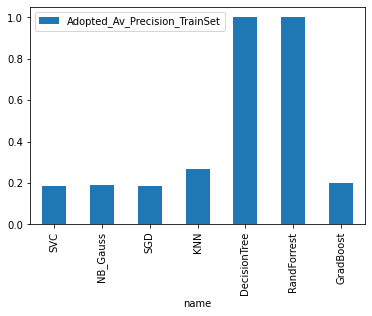

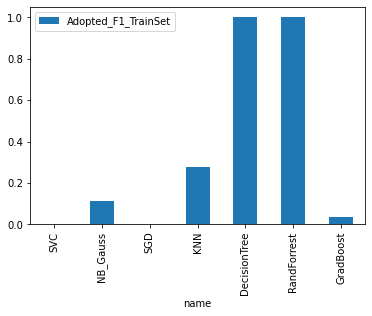

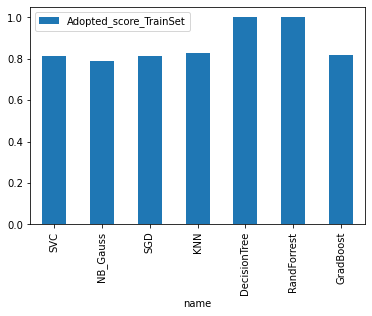

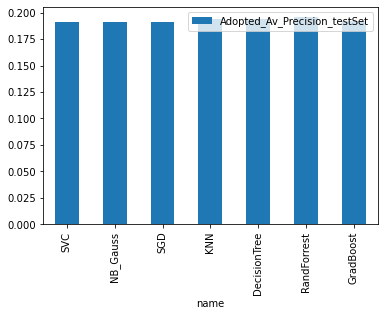

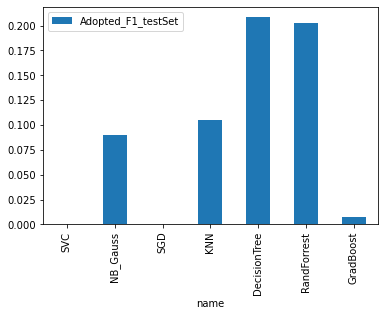

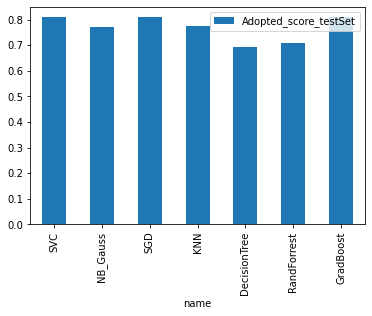

In [12]:
tryModels(X_train, X_test, y_train, y_test)

#### Random Forrest Feature Importance

              precision    recall  f1-score   support

 Not Adopted       0.81      0.83      0.82      2355
     Adopted       0.20      0.18      0.19       557

    accuracy                           0.71      2912
   macro avg       0.51      0.51      0.51      2912
weighted avg       0.69      0.71      0.70      2912



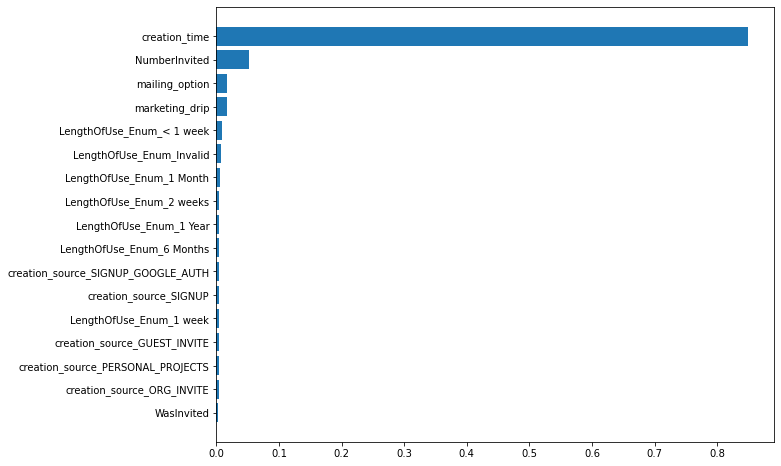

In [13]:
model = RandomForestClassifier()
model.fit(X_train, y_train['Adopted'])
y_pred = model.predict(X_test)
importances =model.feature_importances_
indices = np.argsort(importances)

target_names = ['Not Adopted', 'Adopted']
print(classification_report(y_test['Adopted'], y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

#### Gradient Boosting Feature Importance

              precision    recall  f1-score   support

 Not Adopted       0.81      1.00      0.89      2355
     Adopted       0.50      0.00      0.01       557

    accuracy                           0.81      2912
   macro avg       0.65      0.50      0.45      2912
weighted avg       0.75      0.81      0.72      2912



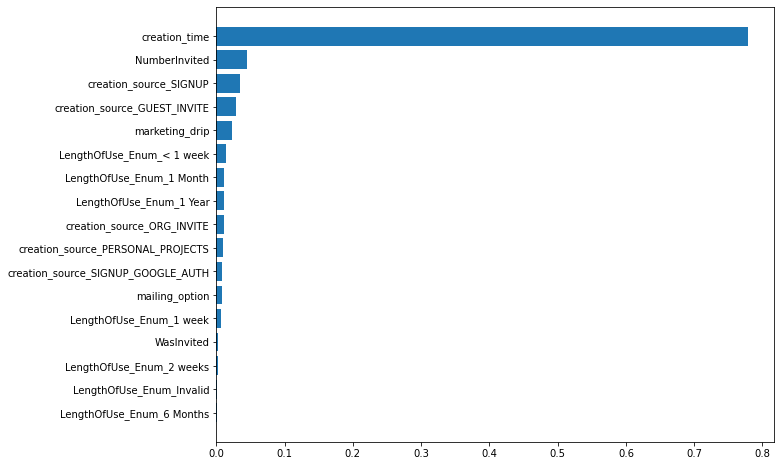

In [14]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train['Adopted'])
y_pred = model.predict(X_test)

importances =model.feature_importances_
indices = np.argsort(importances)

target_names = ['Not Adopted', 'Adopted']
print(classification_report(y_test['Adopted'], y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

#### SGD Feature Importance

              precision    recall  f1-score   support

 Not Adopted       0.81      1.00      0.89      2355
     Adopted       0.00      0.00      0.00       557

    accuracy                           0.81      2912
   macro avg       0.40      0.50      0.45      2912
weighted avg       0.65      0.81      0.72      2912



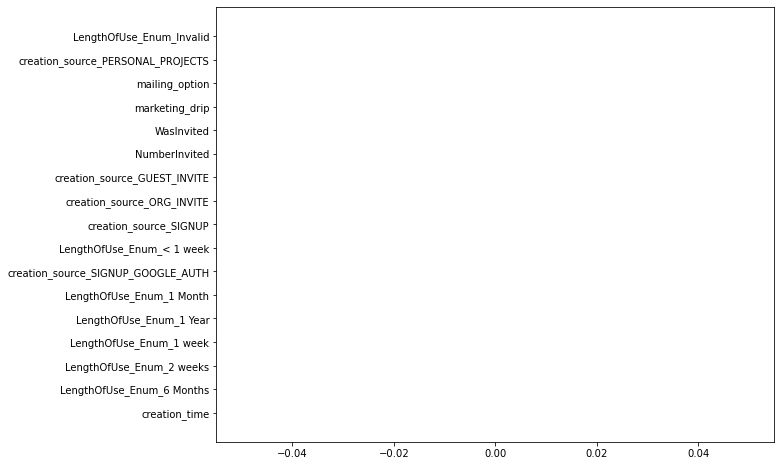

In [15]:
model = SGDClassifier()
model.fit(X_train, y_train['Adopted'])
y_pred = model.predict(X_test)

target_names = ['Not Adopted', 'Adopted']
print(classification_report(y_test['Adopted'], y_pred, target_names=target_names))

perm_importance_result_train = permutation_importance(model, X_train, y_train['Adopted'], n_repeats=5)
plot_feature_importances(perm_importance_result_train, X_train.columns)

## Normalized Subset 2 - Length of Time represented by Seconds

In [16]:
X = usersNormed2.loc[:, usersNormed2.columns!='Adopted']
y = usersNormed2[['Adopted']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

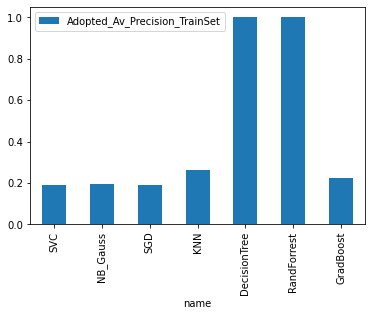

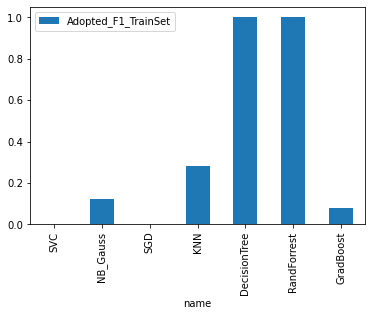

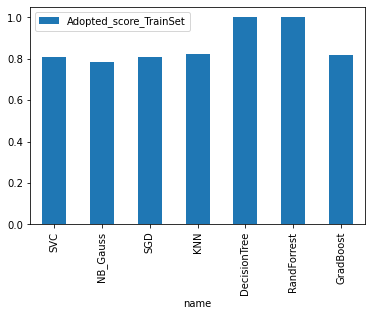

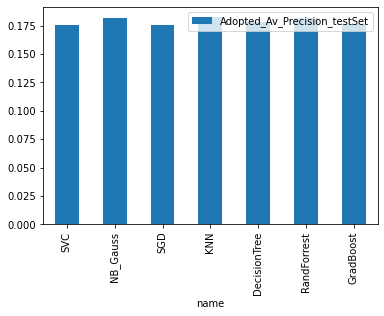

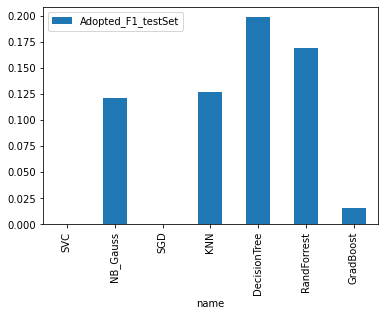

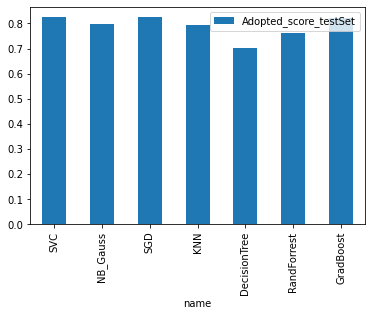

In [17]:
tryModels(X_train, X_test, y_train, y_test)

#### Random Forrest Feature Importance

              precision    recall  f1-score   support

 Not Adopted       0.82      0.89      0.86      1761
     Adopted       0.18      0.11      0.14       376

    accuracy                           0.75      2137
   macro avg       0.50      0.50      0.50      2137
weighted avg       0.71      0.75      0.73      2137



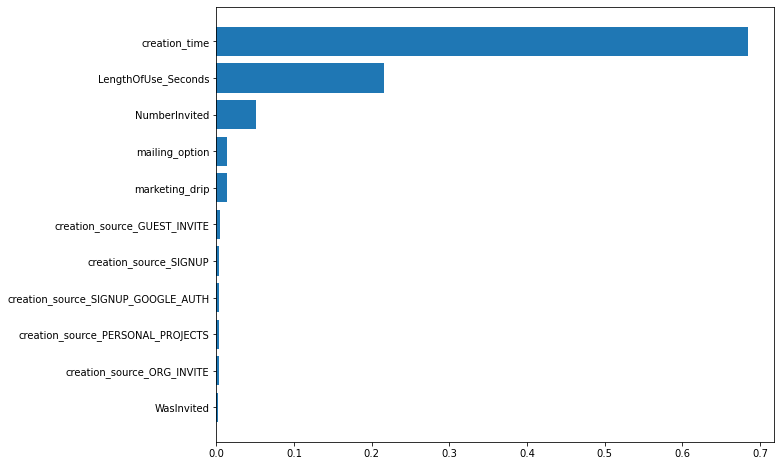

In [18]:
model = RandomForestClassifier()
model.fit(X_train, y_train['Adopted'])
y_pred = model.predict(X_test)
importances =model.feature_importances_
indices = np.argsort(importances)

target_names = ['Not Adopted', 'Adopted']
print(classification_report(y_test['Adopted'], y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

#### Decision Tree Feature Importance

              precision    recall  f1-score   support

 Not Adopted       0.82      0.80      0.81      1761
     Adopted       0.18      0.20      0.19       376

    accuracy                           0.69      2137
   macro avg       0.50      0.50      0.50      2137
weighted avg       0.71      0.69      0.70      2137



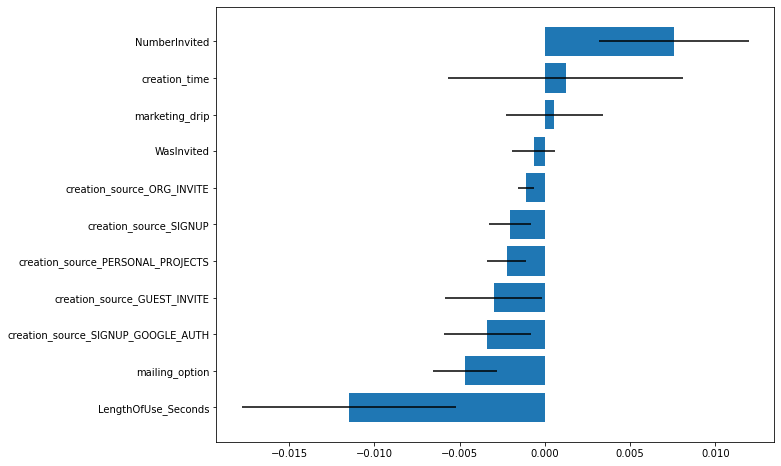

In [19]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train['Adopted'])
y_pred = model.predict(X_test)

importances =model.feature_importances_
indices = np.argsort(importances)

target_names = ['Not Adopted', 'Adopted']
print(classification_report(y_test['Adopted'], y_pred, target_names=target_names))

perm_importance_result_test = permutation_importance(model, X_test, y_test['Adopted'], n_repeats=5)
plot_feature_importances(perm_importance_result_test, X_test.columns)